In [1]:
# Data manipulation and helpful libraries
import numpy as np 
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import itertools
import cv2
import seaborn as sns
from PIL import Image

# Machine Learning libraries
import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

2025-05-04 05:44:13.372586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 05:44:13.707166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746337453.898071   11757 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746337453.964869   11757 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746337454.248821   11757 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
dataset_dir = "archive"
data = []
labels = []

for fold in os.listdir(dataset_dir):
    # Save the subfold names as labels 
    filepaths = os.path.join(dataset_dir, fold)
    for file in os.listdir(filepaths):
        # Save the data path
        data.append(os.path.join(filepaths,file))
        labels.append(fold)

# Convert to a pandas dataframe 
data_ = pd.Series(data, name='paths')
labels_ = pd.Series(labels, name = 'labels')
dataset = pd.concat([data_, labels_], axis=1)

In [3]:
dataset.head()

,paths,labels
0,archive/Anthracnose/20211008_124249 (Custom).jpg,Anthracnose
1,archive/Anthracnose/20211008_124250 (Custom).jpg,Anthracnose
2,archive/Anthracnose/20211008_124252 (Custom).jpg,Anthracnose
3,archive/Anthracnose/20211008_124253 (Custom).jpg,Anthracnose
4,archive/Anthracnose/20211008_124256 (Custom).jpg,Anthracnose


In [4]:
training_data, temp_validation_data = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=42, stratify=dataset['labels'])
validation_data, test_data = train_test_split(temp_validation_data, test_size=0.05, shuffle=True, random_state=42, stratify=temp_validation_data['labels'])
print(f"Dimension of the training data: {training_data.shape[0]}")
print(f"Dimension of the validation data: {validation_data.shape[0]}")
print(f"Dimension of the test data: {test_data.shape[0]}")

Dimension of the training data: 3200
Dimension of the validation data: 760
Dimension of the test data: 40


In [5]:
# Batch size
batch_size = 32
# Dataset image shape
img_shape = (224, 224)

# The original dataset was augmentated
# This function only returns the image as is
def return_image(image):
    return image

# Create a ImageDataGenerator
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image)
validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image)

# Reading the images
training_data_gen = train_gen.flow_from_dataframe(training_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'                                             
                                             )
validation_data_gen = train_gen.flow_from_dataframe(validation_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'                                             
                                             )

Found 3200 validated image filenames belonging to 8 classes.
Found 760 validated image filenames belonging to 8 classes.


In [6]:
def get_img_array(img_path, img_shape):
    # Load image
    img = tf.keras.utils.load_img(img_path, target_size=img_shape) 
    # Convert to array
    array = tf.keras.utils.img_to_array(img) / 255.0    
    # Add a dimension to the array image
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )    

    # Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)    

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, normalizing the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img) 
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    return superimposed_img

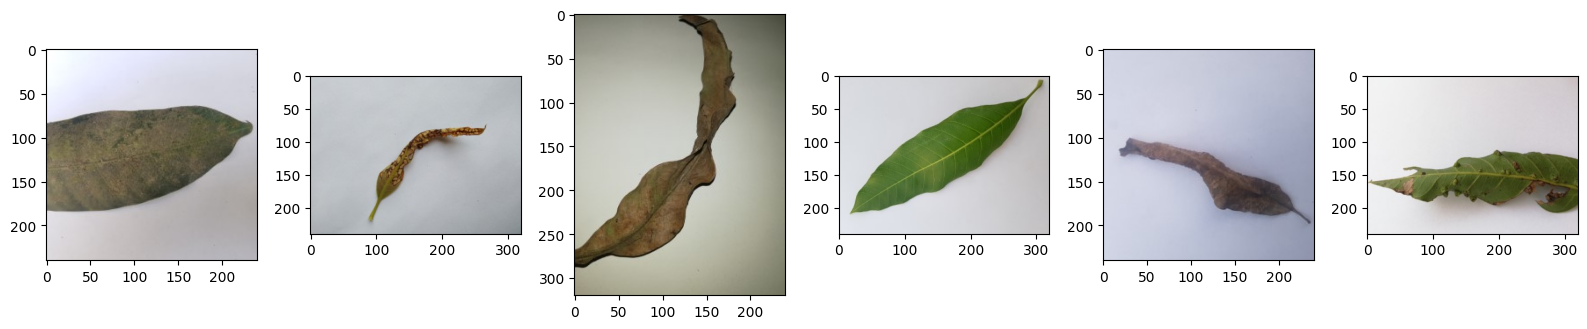

In [7]:
fig, axs = plt.subplots(1,6, figsize=(16,12))
axs[0].imshow(Image.open(test_data.iloc[0,0]))
axs[1].imshow(Image.open(test_data.iloc[1,0]))
axs[2].imshow(Image.open(test_data.iloc[2,0]))
axs[3].imshow(Image.open(test_data.iloc[3,0]))
axs[4].imshow(Image.open(test_data.iloc[4,0]))
axs[5].imshow(Image.open(test_data.iloc[5,0]))
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

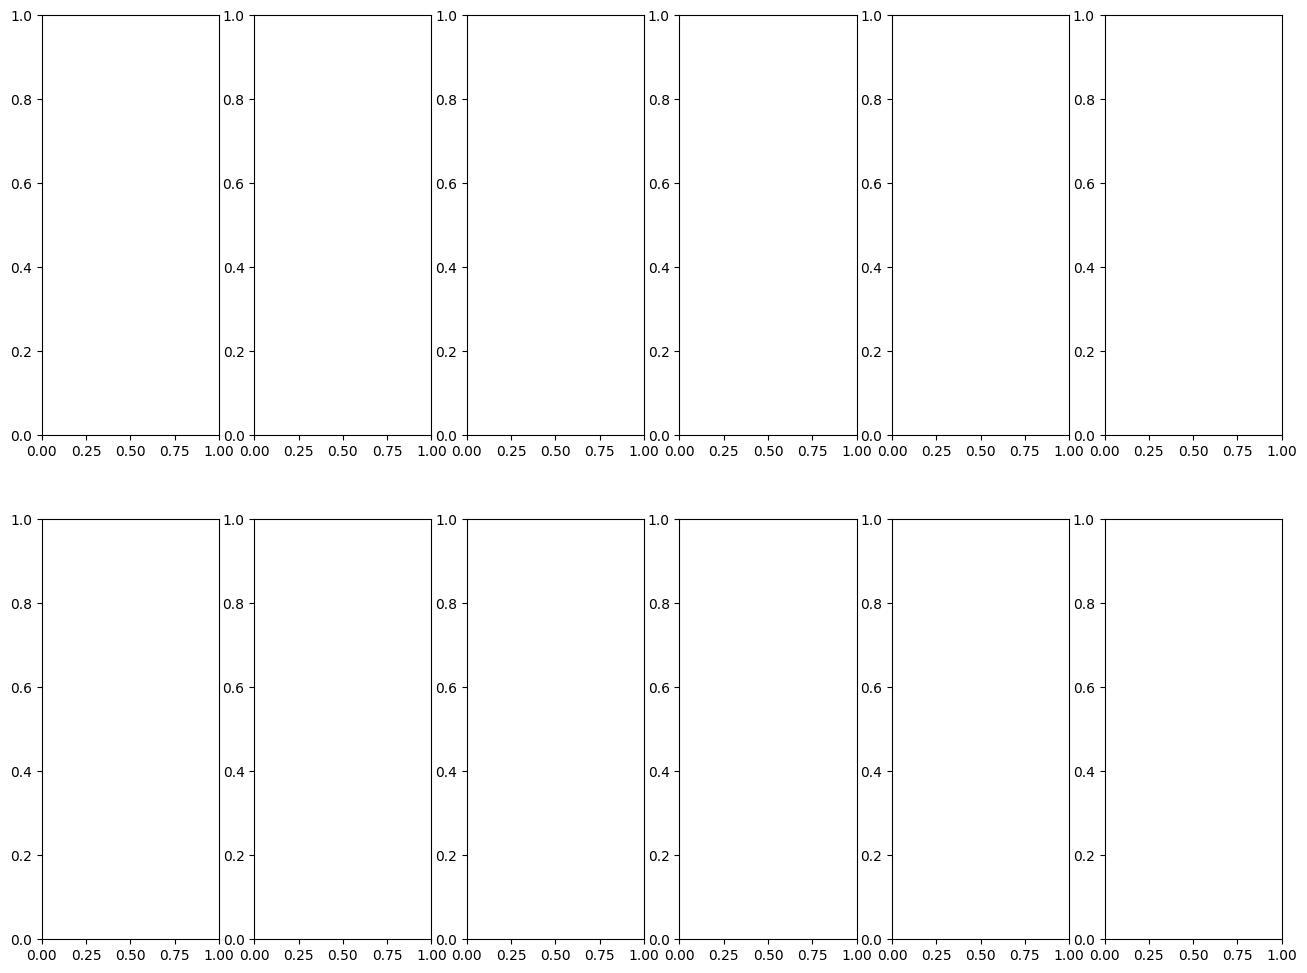

In [8]:
last_conv_layer_name = "max_pooling2d_1"
fig, ax = plt.subplots(2,6, figsize=(16,12))

for i in range(6):
    img_array = get_img_array(test_data.iloc[i,0], img_shape=img_shape)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    ax[0,i].matshow(heatmap)
    # Superpose image and heatmap
    ax[1,i].imshow(display_gradcam(test_data.iloc[i,0], heatmap))


plt.tight_layout()
fig.text(0.5, 0.92, "GRAD-CAM of 6 samples of test set", ha='center', fontsize=20)
fig.text(0.5, 0.49, "Superimposition of heatmap and samples", ha='center', fontsize=20)
plt.show()

In [9]:
# Loading dataset
def load_dataset(folder, img_size=(224, 224)):
    images = []
    labels = []
    for label in os.listdir(folder):
        file_path = os.path.join(folder, label)
        if os.path.isdir(file_path):
            for file in os.listdir(file_path):
                img_path = os.path.join(file_path, file)
                # Read image
                image = cv2.imread(img_path)
                # Convert from BGR color space to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Resize image
                image = cv2.resize(image, img_size)
                images.append(image)
                labels.append(label)
    # Converting to numpy array
    return np.array(images), np.array(labels)
dataset_path="archive"

X, y = load_dataset(dataset_path)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Load base pretrained VGG16 model
base_model = tf.keras.applications.VGG16(
                                          include_top= False,
                                          weights= "imagenet",
                                          input_shape= (224,224,3)
)

In [54]:
# Freezing weights of base model
base_model.trainable = False
# Creating Sequential Model
deep_feat_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(
    #     256,
    #     kernel_regularizer=tf.keras.regularizers.l2(0.016),
    #     activity_regularizer=tf.keras.regularizers.l1(0.006),
    #     bias_regularizer=tf.keras.regularizers.l1(0.006),
    #     activation="linear"
    # )
])

In [55]:
train_features = deep_feat_model.predict(X_train)
test_features = deep_feat_model.predict(X_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step


In [56]:
train_features.shape

(3200, 512)

In [57]:
training_flatten = train_features.reshape(train_features.shape[0], -1)
test_flatten = test_features.reshape(test_features.shape[0], -1)

In [58]:
knn_model = KNeighborsClassifier()
knn_model.fit(training_flatten, y_train)

KNeighborsClassifier()

In [59]:
y_pred = knn_model.predict(test_flatten)

                  precision    recall  f1-score   support

     Anthracnose       1.00      0.89      0.94       123
Bacterial Canker       1.00      1.00      1.00        86
  Cutting Weevil       1.00      1.00      1.00       112
        Die Back       0.94      1.00      0.97       101
      Gall Midge       0.93      0.95      0.94       104
         Healthy       0.91      1.00      0.95        90
  Powdery Mildew       0.95      0.97      0.96        91
     Sooty Mould       1.00      0.94      0.97        93

        accuracy                           0.96       800
       macro avg       0.97      0.97      0.97       800
    weighted avg       0.97      0.96      0.96       800



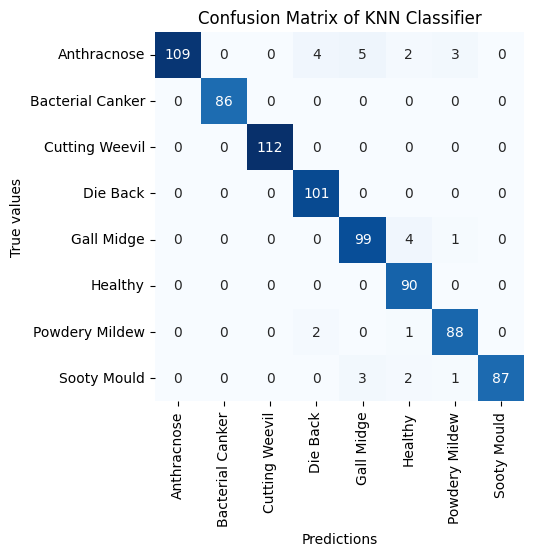

In [60]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix for each class
class_names = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
               "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of KNN Classifier')
plt.show()

# Comparison models

                  precision    recall  f1-score   support

     Anthracnose       0.97      0.98      0.97       123
Bacterial Canker       1.00      0.99      0.99        86
  Cutting Weevil       1.00      1.00      1.00       112
        Die Back       0.99      0.99      0.99       101
      Gall Midge       0.97      0.97      0.97       104
         Healthy       0.98      0.99      0.98        90
  Powdery Mildew       0.98      0.98      0.98        91
     Sooty Mould       0.97      0.96      0.96        93

        accuracy                           0.98       800
       macro avg       0.98      0.98      0.98       800
    weighted avg       0.98      0.98      0.98       800



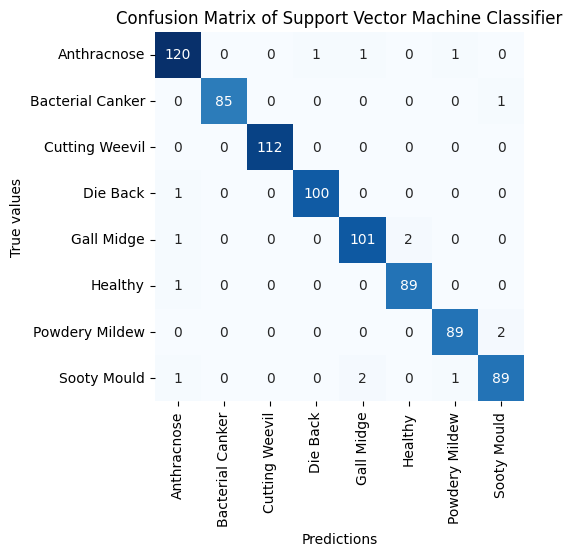

In [20]:
from sklearn.svm import SVC
svm_model = SVC()
# Fit model
svm_model.fit(training_flatten, y_train)
# Predict
y_pred_svm = svm_model.predict(test_flatten)
# Classification report
print(classification_report(y_test, y_pred_svm))
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of Support Vector Machine Classifier')
plt.show()

In [43]:
import joblib

# Save the trained SVM model
joblib.dump(knn_model, "knn_model.pkl")

['knn_model.pkl']

In [22]:
import json

# Save class names
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

In [24]:
deep_feat_model.save("deep_feat_model.h5")

In [23]:
# Load the saved SVM model and class names
svm_model = joblib.load("svm_model.pkl")

with open("class_names.json", "r") as f:
    class_names = json.load(f)

NameError: name 'test_data' is not defined

In [8]:
import cv2
import numpy as np
import tensorflow as tf
import joblib
import json

# Load saved models
deep_feat_model = tf.keras.models.load_model("deep_feat_model.h5")
model = joblib.load("svm_model.pkl")

# Load class names
with open("class_names.json", "r") as f:
    class_names = json.load(f)

# Preprocess input image
def preprocess_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalize if needed
    return np.expand_dims(image, axis=0)

# Path to new image
image_path = "archive/Cutting Weevil/20211011_131115 (Custom).jpg"

# Preprocess and extract features
img = preprocess_image(image_path)
features = deep_feat_model.predict(img)
flattened = features.reshape(features.shape[0], -1)

# Predict
prediction = model.predict(flattened)
predicted_class = prediction[0]

print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Die Back
